In [ ]:
import torch
import zipfile
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class PGD:
    def __init__(self, model, epsilon=0.03, alpha=2/255, iterations=40):
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha
        self.iterations = iterations

    def generate(self, data, target):
        data.requires_grad = True
        output = self.model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        self.model.zero_grad()
        loss.backward()
        perturbed_data = data + self.alpha * data.grad.sign()
        perturbed_data = torch.clamp(perturbed_data, 0, 1)
        return perturbed_data

class FGSM:
    def __init__(self, model, epsilon=0.03):
        self.model = model
        self.epsilon = epsilon

    def generate(self, data, target):
        data.requires_grad = True
        output = self.model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        self.model.zero_grad()
        loss.backward()
        perturbed_data = data + self.epsilon * data.grad.sign()
        perturbed_data = torch.clamp(perturbed_data, 0, 1)
        return perturbed_data

class CW:
    def __init__(self, model, targeted=False, c=1e-2, kappa=5, lr=0.005, n_iters=1000):
        self.model = model
        self.targeted = targeted
        self.c = c
        self.kappa = kappa
        self.lr = lr
        self.n_iters = n_iters

    def generate(self, data, target):
        data = data.clone().detach().to(torch.float32).requires_grad_(True)
        target = target.clone().detach()

        delta = torch.zeros_like(data, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=self.lr)

        for _ in range(self.n_iters):
            adv_data = torch.tanh(data + delta)
            outputs = self.model(adv_data)

            # Compute loss
            real = outputs.gather(1, target.view(-1, 1)).squeeze()
            other = (outputs - torch.eye(outputs.shape[1], device=outputs.device)[target]).max(dim=1)[0]
            if self.targeted:
                loss1 = torch.clamp(other - real + self.kappa, min=0)
            else:
                loss1 = torch.clamp(real - other + self.kappa, min=0)
            loss2 = torch.sum(delta ** 2)
            loss = self.c * loss1.sum() + loss2

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        adv_data = torch.tanh(data + delta).detach()
        return adv_data

In [ ]:
#Resnet50

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.batch_norm3(self.conv3(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layers, num_classes, channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layers[0], out_channels=64)
        self.layer2 = self._make_layer(ResBlock, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, out_channels, stride=1):
        i_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * ResBlock.expansion:
            i_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * ResBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, out_channels, i_downsample, stride))
        self.in_channels = out_channels * ResBlock.expansion

        for _ in range(1, blocks):
            layers.append(ResBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

def get_resnet50_model():
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=3, channels=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/lung_dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/lung_dataset')

print("Extracted files:", os.listdir('/content/lung_dataset'))

train_dir = '/content/lung_dataset/mini_dataset/train'
val_dir = '/content/lung_dataset/mini_dataset/validate'
test_dir = '/content/lung_dataset/mini_dataset/test'


# preprocessing transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

print("Contents of train directory:", os.listdir(train_dir) if os.path.exists(train_dir) else "Train directory not found")
print("Contents of validate directory:", os.listdir(val_dir) if os.path.exists(val_dir) else "Validate directory not found")
print("Contents of test directory:", os.listdir(test_dir) if os.path.exists(test_dir) else "Test directory not found")

Mounted at /content/drive
Extracted files: ['mini_dataset']
Training set size: 771
Validation set size: 165
Test set size: 160
Contents of train directory: ['Normal', 'Benign', 'Malignant']
Contents of validate directory: ['Normal', 'Benign', 'Malignant']
Contents of test directory: ['Normal', 'Benign', 'Malignant']


In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
print(train_data.class_to_idx)

{'Benign': 0, 'Malignant': 1, 'Normal': 2}


In [ ]:
def train(model, train_loader, val_loader, pgd_attack, fgsm_attack, cw_attack, num_epochs=200):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    total_correct=0
    total_samples=0
    model_path = "model_resnet_50.pth"

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.cuda(), target.cuda()

            pgd_data = pgd_attack.generate(data, target)
            fgsm_data = fgsm_attack.generate(data, target)
            cw_data = cw_attack.generate(data, target)

            combined_data = torch.cat([data, pgd_data, fgsm_data, cw_data], 0)
            combined_target = torch.cat([target, target, target, target], 0)

            optimizer.zero_grad()

            output = model(combined_data)

            loss = criterion(output, combined_target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == combined_target).sum().item()
            total_samples += combined_target.size(0)
        accuracy = 100 * total_correct / total_samples

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                val_acc += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_acc / len(val_loader.dataset)

        torch.save(model.state_dict(), model_path)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {accuracy:.2f}%")

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        print(f"Model saved to {model_path}")

In [ ]:
def test(model, test_loader, pgd_attack, fgsm_attack, cw_attack):
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0

    with torch.no_grad():
        # Clean Data Evaluation
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            total += target.size(0)

            clean_output = model(data)
            clean_pred = clean_output.argmax(dim=1, keepdim=True)
            clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()

    # Adversarial Data Evaluation
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data.requires_grad = True

        for attack in [pgd_attack, fgsm_attack, cw_attack]:
            adv_data = attack.generate(data, target).to(data.device)
            adv_output = model(adv_data)
            adv_pred = adv_output.argmax(dim=1, keepdim=True)
            adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()

            # Free GPU memory
            del adv_data, adv_output, adv_pred
            torch.cuda.empty_cache()

    clean_acc = 100. * clean_correct / total
    adv_acc = 100. * adv_correct / (total * 3)

    print(f"Clean Test Accuracy: {clean_acc:.2f}%")
    print(f"Adversarial Test Accuracy: {adv_acc:.2f}%")
    return clean_acc, adv_acc


In [ ]:
def test(model, test_loader, pgd_attack, fgsm_attack, cw_attack):
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            total += target.size(0)
            clean_output = model(data)
            clean_pred = clean_output.argmax(dim=1, keepdim=True)
            clean_correct += clean_pred.eq(target.view_as(clean_pred)).sum().item()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        for attack in [pgd_attack, fgsm_attack, cw_attack]:
            adv_data = attack.generate(data, target).to(data.device)
            adv_output = model(adv_data)
            adv_pred = adv_output.argmax(dim=1, keepdim=True)
            adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()

            del adv_data, adv_output, adv_pred
            torch.cuda.empty_cache()

    clean_acc = 100. * clean_correct / total
    adv_acc = 100. * adv_correct / (total * 3)

    print(f"Clean Test Accuracy: {clean_acc:.2f}%")
    print(f"Adversarial Test Accuracy: {adv_acc:.2f}%")
    return clean_acc, adv_acc

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "model_resnet50.pth"

    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    pgd_attack = PGD(model)
    fgsm_attack = FGSM(model)
    cw_attack = CW(model)

    clean_acc, adv_acc = test(model, test_loader, pgd_attack, fgsm_attack, cw_attack)

<ipython-input-81-1aec3131a268>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Clean Test Accuracy: 95.00%
Adversarial Test Accuracy: 94.58%


<ipython-input-82-c6ad4b257709>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Malignant
Probabilities: [1.3002705e-13 1.0000000e+00 4.3740893e-34]
Chosen Attack: pgd
Adversarial Predicted Label: Malignant


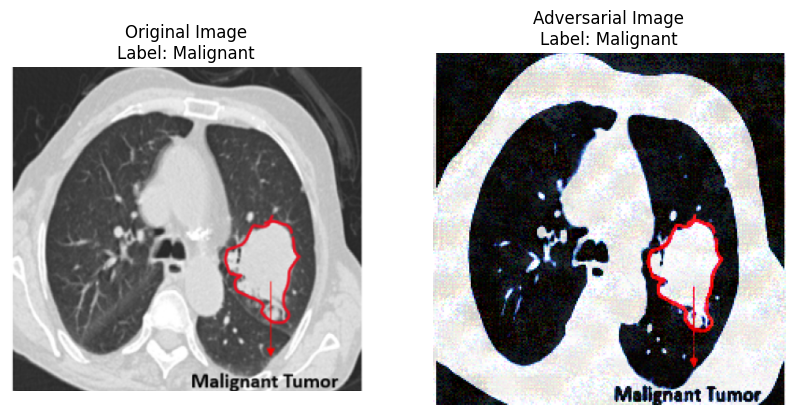

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "mal3.png"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-83-1ec8b4b32a27>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Normal
Probabilities: [0.03925289 0.0086796  0.95206755]
Chosen Attack: pgd
Adversarial Predicted Label: Normal


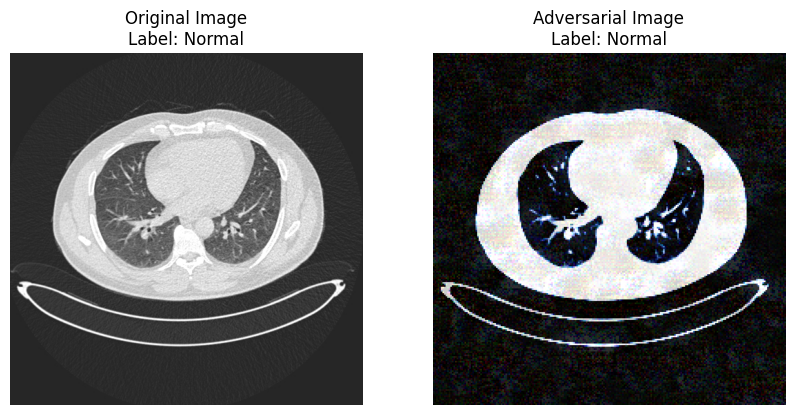

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "normal_1.jpeg"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-84-764e3b6924f8>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Benign
Probabilities: [9.9999845e-01 1.4916295e-06 5.9248099e-11]
Chosen Attack: fgsm
Adversarial Predicted Label: Benign


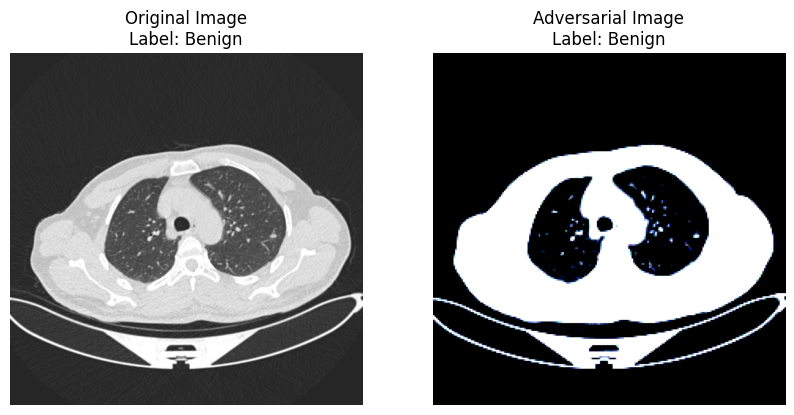

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "ben_1.jpeg"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-85-0a948079a587>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Normal
Probabilities: [3.6326045e-10 1.4205470e-07 9.9999988e-01]
Chosen Attack: pgd
Adversarial Predicted Label: Normal


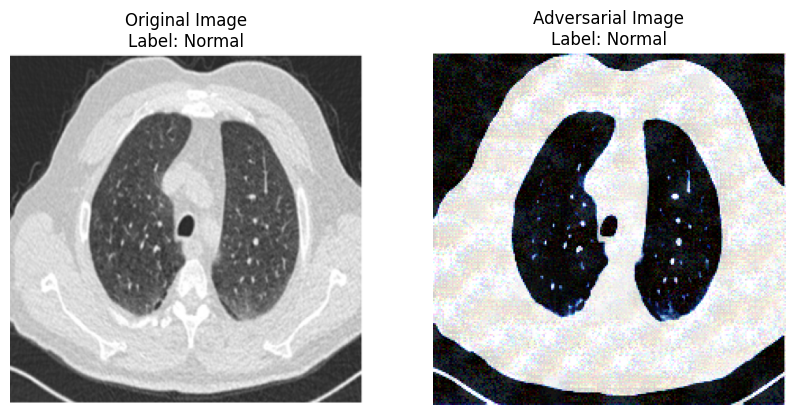

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "normal_2.png"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-86-e5fd2988b9f8>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Malignant
Probabilities: [1.2246963e-08 9.9999928e-01 6.8893638e-07]
Chosen Attack: fgsm
Adversarial Predicted Label: Malignant


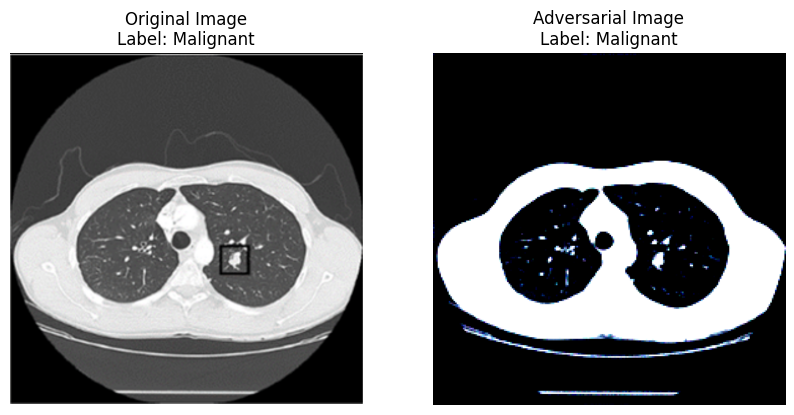

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "malignant_1.png"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-87-2d24b6e9f353>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Malignant
Probabilities: [1.3236317e-08 9.9999917e-01 8.2761505e-07]
Chosen Attack: cw
Adversarial Predicted Label: Malignant


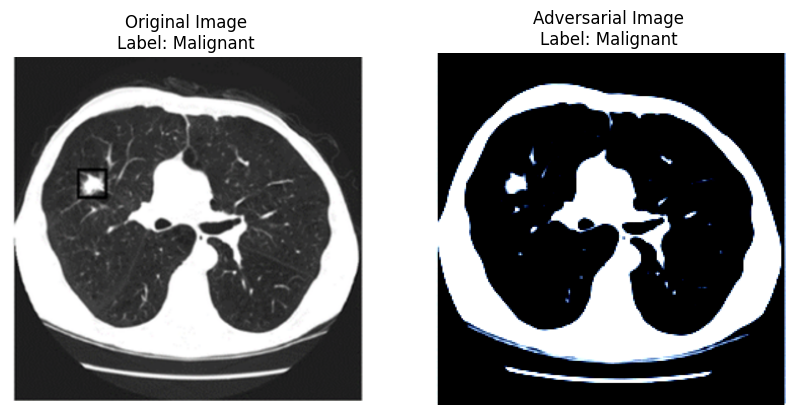

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "malignant_2.png"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)


<ipython-input-88-864e90495103>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Original Predicted Label: Benign
Probabilities: [0.62369543 0.2663126  0.10999195]
Chosen Attack: fgsm
Adversarial Predicted Label: Benign


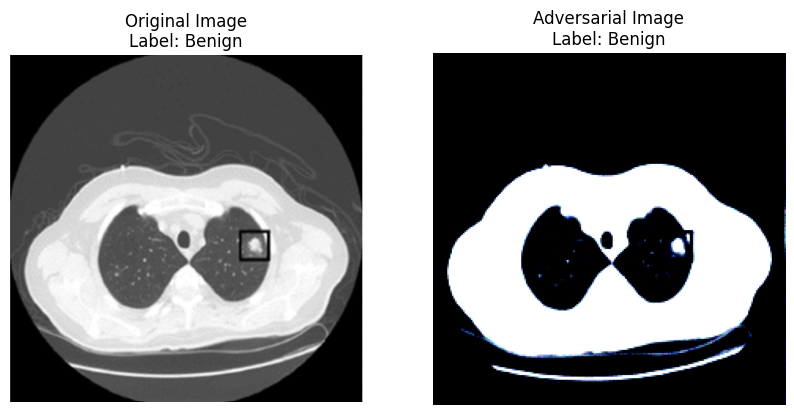

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import random

class_labels = ['Benign', 'Malignant', 'Normal']

def get_resnet50_model():
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path, device):
    model = get_resnet50_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities, image, input_tensor

def pgd_attack(model, image, target, epsilon=0.01, alpha=0.005, num_steps=40):
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(image)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()

        if image.grad is None:
            raise ValueError("Gradients for the image are not being computed. Ensure requires_grad=True.")
        grad_sign = image.grad.sign()
        image = image + alpha * grad_sign
        image = image.detach()
        image = torch.clamp(image, 0, 1).requires_grad_(True)

    return image

def fgsm_attack(model, image, target, epsilon=0.1):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    image = image + epsilon * image.grad.sign()
    image = torch.clamp(image, 0, 1)
    return image

def cw_attack(model, image, target, c=1e-4, kappa=0, num_steps=1000, learning_rate=0.01):
    adversarial_image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        output = model(adversarial_image)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=len(class_labels)).float()
        real = torch.sum(target_one_hot * output, dim=1)
        other = torch.max((1 - target_one_hot) * output - target_one_hot * 1e4, dim=1).values
        loss = torch.clamp(real - other + kappa, min=0).sum() + c * torch.norm((adversarial_image - image), p=2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adversarial_image = torch.clamp(adversarial_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image

def plot_images(original_image, adversarial_image, original_label, adversarial_label):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nLabel: {original_label}")
    axs[0].axis('off')

    adversarial_image = adversarial_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    axs[1].imshow(adversarial_image)
    axs[1].set_title(f"Adversarial Image\nLabel: {adversarial_label}")
    axs[1].axis('off')

    plt.show()

if __name__ == "__main__":
    model_path = "model_resnet50.pth"
    random_image_path = "benign_6.png"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = load_model(model_path, device)

    original_label, probabilities, original_image, input_tensor = predict_image(random_image_path, model, transform, device)

    print(f"Original Predicted Label: {original_label}")
    print(f"Probabilities: {probabilities.cpu().numpy()}")

    attack_choice = random.choice(["pgd", "fgsm", "cw"])
    print(f"Chosen Attack: {attack_choice}")

    if attack_choice == "pgd":
        adversarial_image = pgd_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "fgsm":
        adversarial_image = fgsm_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))
    elif attack_choice == "cw":
        adversarial_image = cw_attack(model, input_tensor, torch.tensor([class_labels.index(original_label)]).to(device))

    adversarial_label, _, _, _ = predict_image(random_image_path, model, transform, device)

    print(f"Adversarial Predicted Label: {adversarial_label}")

    plot_images(original_image, adversarial_image, original_label, adversarial_label)
